In [5]:
import cv2
import os

def empty_folder(folder):
    # Check if the folder exists
    if not os.path.exists(folder):
        return
    
    # Get the list of files in the folder
    files = os.listdir(folder)
    
    # Loop through the files and remove them
    for file in files:
        file_path = os.path.join(folder, file)
        os.remove(file_path)

def extract_frames(mp4_path, start_frame, end_frame, stride, save_dir='data/mario', size = (64,64)):
    # Open the video file
    video = cv2.VideoCapture(mp4_path)
    empty_folder(save_dir)
    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frames in video:", total_frames)
    # Validate the start and end frame numbers
    if start_frame < 0 or start_frame >= total_frames:
        raise ValueError("Invalid start frame number")
    if end_frame < 0 or end_frame >= total_frames:
        raise ValueError("Invalid end frame number")
    if start_frame > end_frame:
        raise ValueError("Start frame number cannot be greater than end frame number")
    
    # Validate the stride value
    if stride <= 0:
        raise ValueError("Stride value must be greater than zero")
    
    # Set the current frame number to the start frame
    current_frame = start_frame
    
    # List to store the extracted frames
    frames = []
    
    # Loop through the frames and extract the desired frames
    while current_frame <= end_frame:
        # Set the current frame number
        video.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        
        # Read the frame
        ret, frame = video.read()
        
        # Check if the frame was read successfully
        if not ret:
            raise ValueError("Error reading frame")
        
        # Resize the frame to the specified size
        frame = cv2.resize(frame, size)
        # Save the frame to the save_dir
        cv2.imwrite(os.path.join(save_dir, f"frame_{current_frame}.jpg"), frame)
        # Append the frame to the list
        frames.append(frame)
        
        # Increment the current frame number by the stride
        current_frame += stride
    
    # Release the video file
    video.release()
    
    return frames

Frame number: 5000


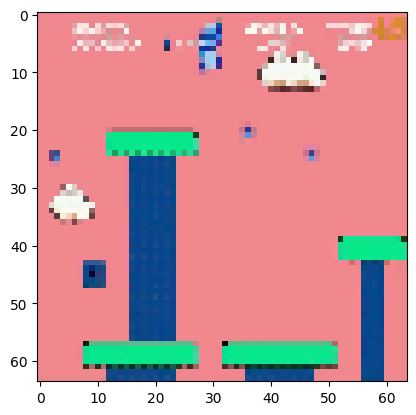

In [7]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

i = 33
for i in range(0, len(frames), 10):
    clear_output(wait=True)  # Clear the output of the current cell
    plt.imshow(frames[i])
    print("Frame number:", start + stride * i)
    plt.show()
    time.sleep(0.03)  # Add a 1-second wait time

In [6]:
path_dir = 'data/mario/'
image_files = [f for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]
len(image_files)

201

In [14]:
start = 400
end = 5000
stride = 2
frames = extract_frames("data/videos/mario_gameplay.mp4", start, end, stride, size=(64,64))

Total frames in video: 69878


In [8]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

transform = transforms.Compose([
    transforms.Resize((64, 64)),    # Resize images to 128x128
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
class marioDataset(Dataset):
    def __init__(self, path_dir, num_frames=4, transform=None):
        self.dir = path_dir
        self.num_frames = num_frames
        self.transform = transform
        self.image_files = [f for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]

    def __len__(self):
        return len(self.image_files)//self.num_frames 
    
    def __getitem__(self, idx):
        # Load the image from the file
        images = []
        for i in range(self.num_frames):
            img_path = os.path.join(self.dir, self.image_files[idx + i])
            with Image.open(img_path).convert("RGB") as image:
                image = self.transform(image)
                images.append(image)
        images = torch.stack(images)
        return images
    
dataset = marioDataset(path_dir='data/mario/', transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate through the DataLoader
for batch in data_loader:
    print(batch.shape)
    break 

torch.Size([4, 4, 3, 64, 64])


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

from torch import nn 
import numpy as np
class residualBlock(nn.Module):
    def __init__(self, ni, nf, use_batchnorm=True): 
        super().__init__()
        self.ni = ni
        self.nf = nf
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(nf) if use_batchnorm else nn.Identity()
        self.bn2 = nn.BatchNorm2d(nf) if use_batchnorm else nn.Identity()
        if ni == nf:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(ni, nf, kernel_size=1, stride=1)
    def forward(self, x):
        residue = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + self.skip(residue)
        x = self.relu(x)
        return x

class downSample(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x
    
class upSample(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.upSample = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x):
        x = self.upSample(x)
        x = self.conv(x)
        x = self.relu(x)
        return x
    
class vae(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            downSample(3, 16),
            residualBlock(16, 16),
            residualBlock(16, 32),
            downSample(32, 32),
            residualBlock(32, 32),
            residualBlock(32, 64),
            downSample(64, 64)
        )
        self.decoder = nn.Sequential(
            upSample(64, 64),
            residualBlock(64, 32),
            residualBlock(32, 32),
            upSample(32, 32),
            residualBlock(32, 16),
            residualBlock(16, 16),
            upSample(16, 3)
        )
        self.loss_func = nn.MSELoss()
        self.fc1 = nn.Linear(8 * 8 * 64, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 8 * 8 * 64)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std
    
    def forward(self, x):
        latent = self.encoder(x)
        latent = latent.view(-1, 8 * 8 * 64)
        latent = self.fc1(latent)
        out = self.fc2(latent)
        out = out.view(-1, 64, 8, 8)
        out = self.decoder(out)
        loss = self.loss_func(out, x)
        return loss, out, latent
    
def sample_image(model, dataset):
    model.eval()
    with torch.no_grad():
        random_idx = np.random.randint(0, len(dataset))
        random_image = dataset[random_idx].view(-1, 3, 64, 64).to(device)
        loss, reconstructed_image, latent_space = model(random_image)
        print("original image")
        plt.figure(figsize=(3,3))
        plt.imshow(random_image.squeeze(0).transpose(2,0).transpose(0,1).cpu())
        plt.axis('off')
        plt.show()
        print("reconstructed image")
        plt.figure(figsize=(3,3))
        plt.imshow(reconstructed_image.squeeze(0).transpose(2,0).transpose(0,1).cpu())
        plt.axis('off')
        plt.show()


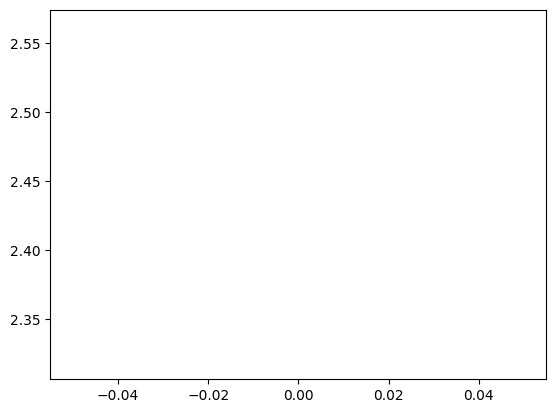

loss: 2.4403, epoch: 0, batch: 0
New learning rate: 0.0001


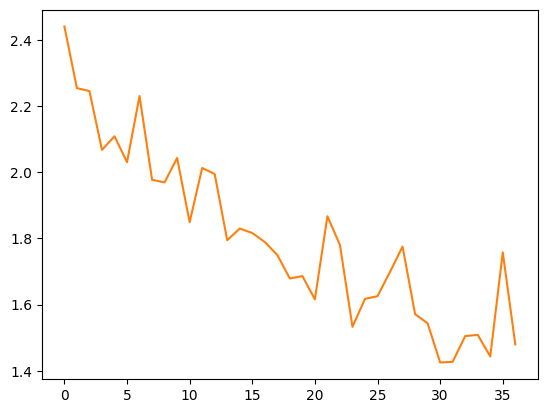

loss: 1.8039, epoch: 1, batch: 0
New learning rate: 0.0001


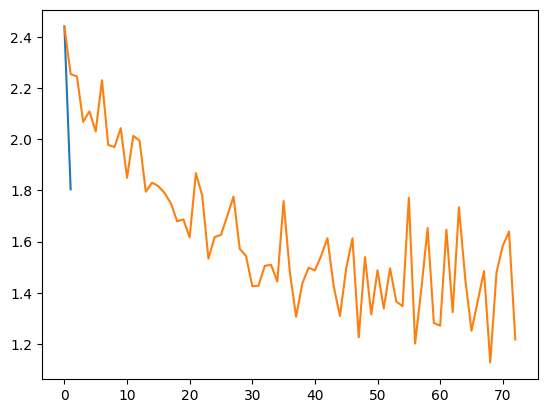

loss: 1.6231, epoch: 2, batch: 0
New learning rate: 0.0001


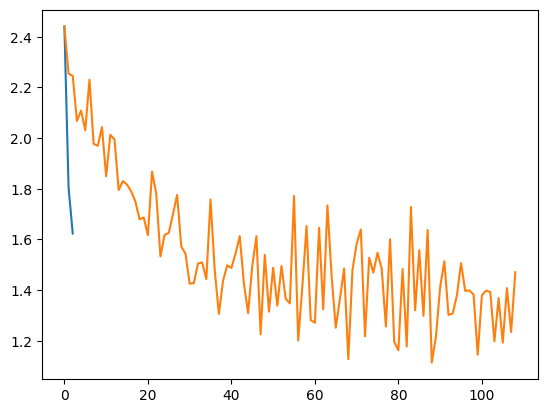

loss: 1.5417, epoch: 3, batch: 0
New learning rate: 0.0001


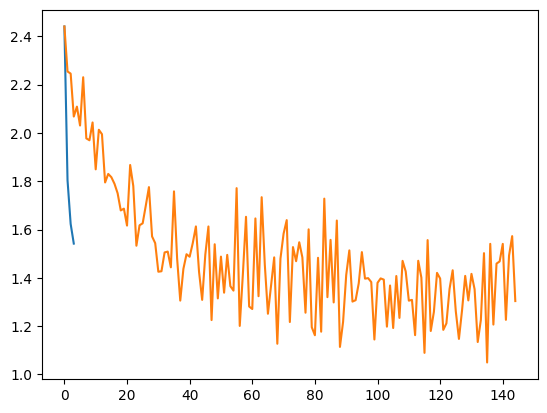

loss: 1.4902, epoch: 4, batch: 0
New learning rate: 0.0001


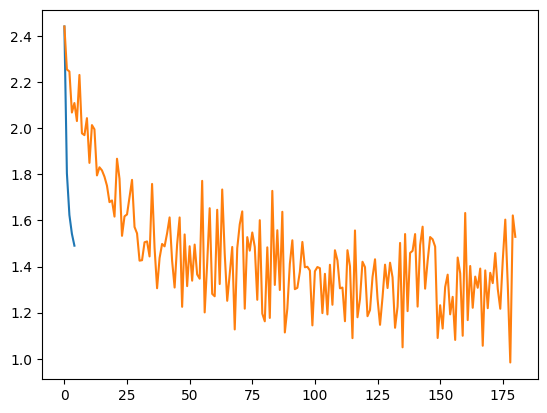

loss: 1.4581, epoch: 5, batch: 0
New learning rate: 0.0001


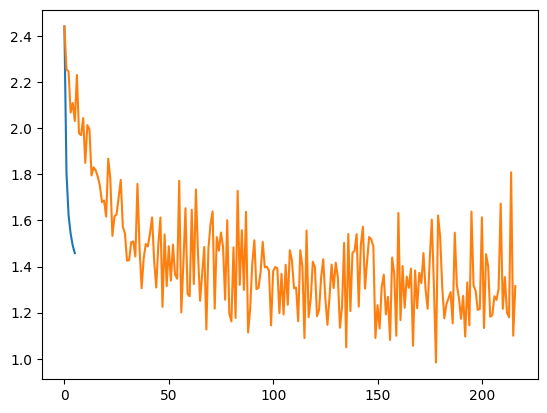

loss: 1.4323, epoch: 6, batch: 0
New learning rate: 0.0001


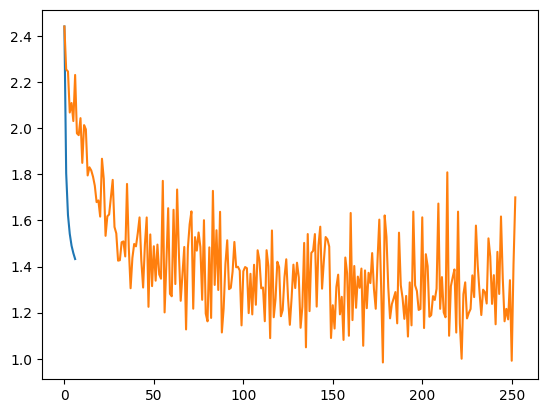

loss: 1.4150, epoch: 7, batch: 0
New learning rate: 0.0001


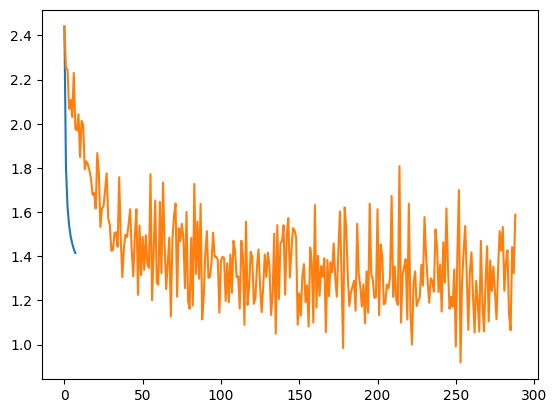

loss: 1.3993, epoch: 8, batch: 0
New learning rate: 0.0001


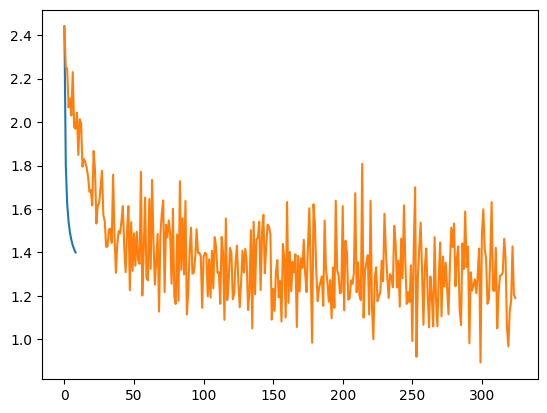

loss: 1.3854, epoch: 9, batch: 0
New learning rate: 0.0001


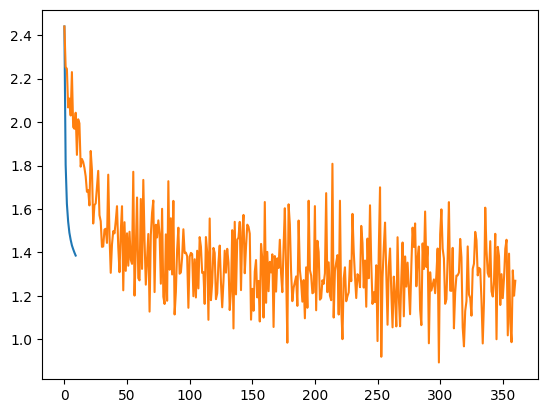

loss: 1.3750, epoch: 10, batch: 0
New learning rate: 0.0001


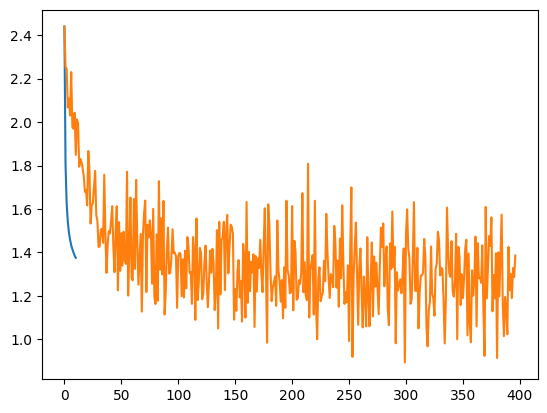

loss: 1.3663, epoch: 11, batch: 0
New learning rate: 0.0001


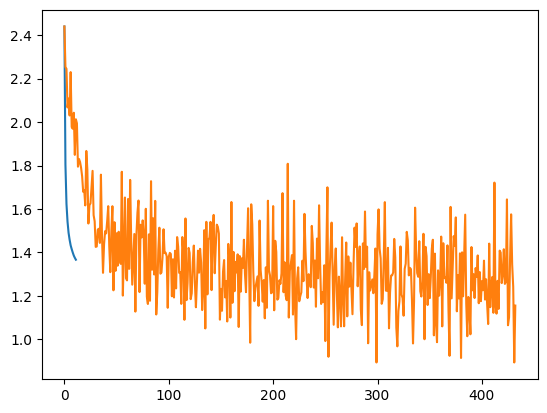

loss: 1.3578, epoch: 12, batch: 0
New learning rate: 0.0001


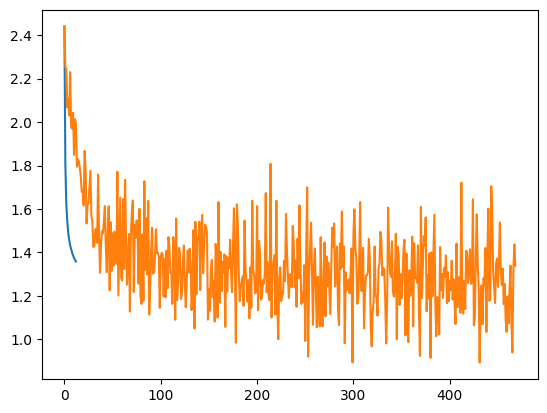

loss: 1.3515, epoch: 13, batch: 0
New learning rate: 0.0001


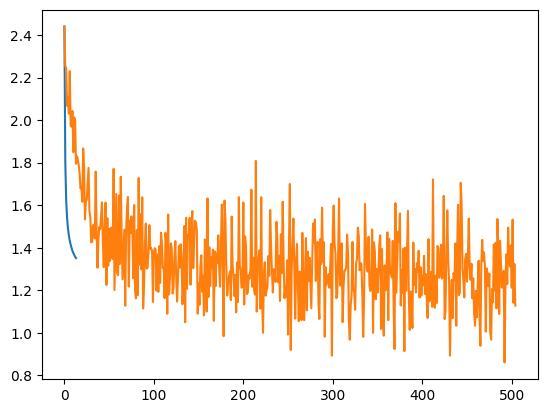

loss: 1.3449, epoch: 14, batch: 0
New learning rate: 0.0001


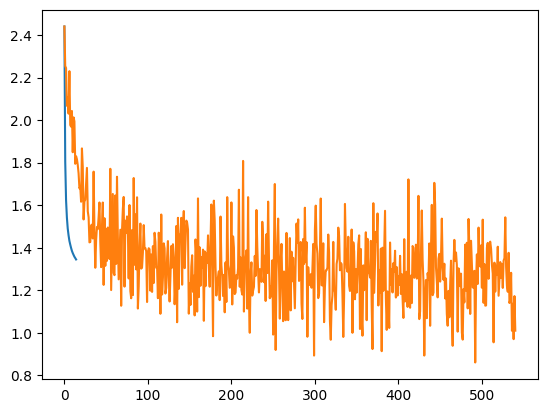

loss: 1.3391, epoch: 15, batch: 0
New learning rate: 0.0001


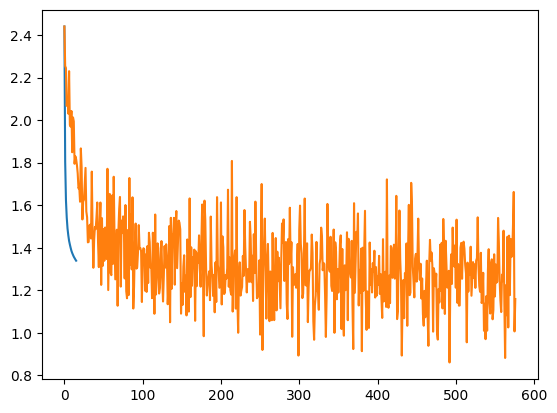

loss: 1.3344, epoch: 16, batch: 0
New learning rate: 0.0001


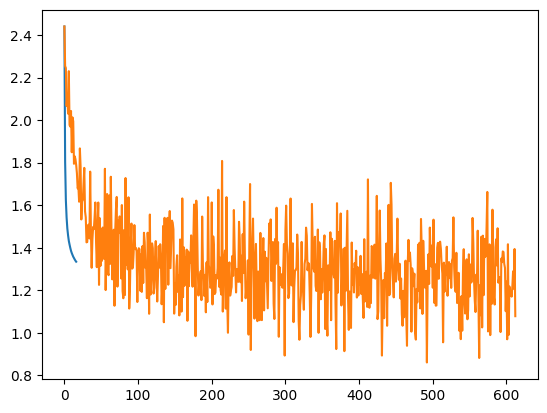

loss: 1.3297, epoch: 17, batch: 0
New learning rate: 0.0001


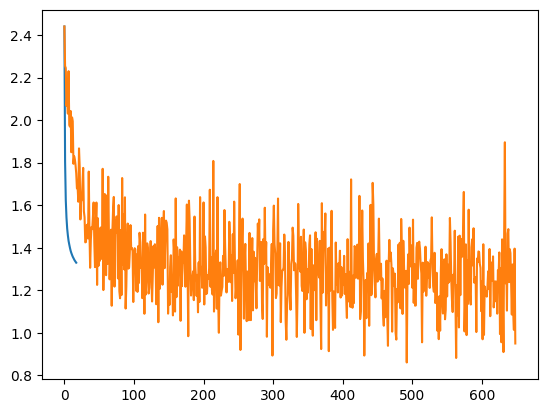

loss: 1.3254, epoch: 18, batch: 0
New learning rate: 0.0001


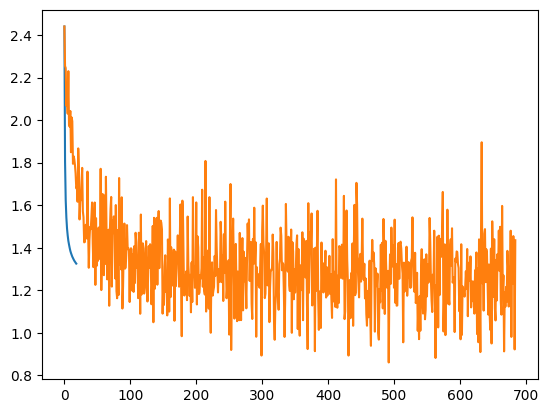

loss: 1.3222, epoch: 19, batch: 0
New learning rate: 0.0001


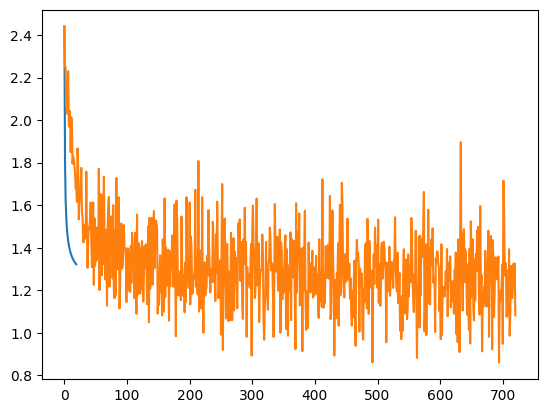

loss: 1.3179, epoch: 20, batch: 0
New learning rate: 0.0001


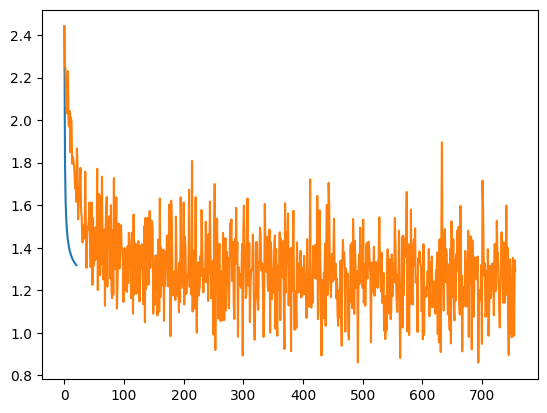

loss: 1.3147, epoch: 21, batch: 0
New learning rate: 0.0001


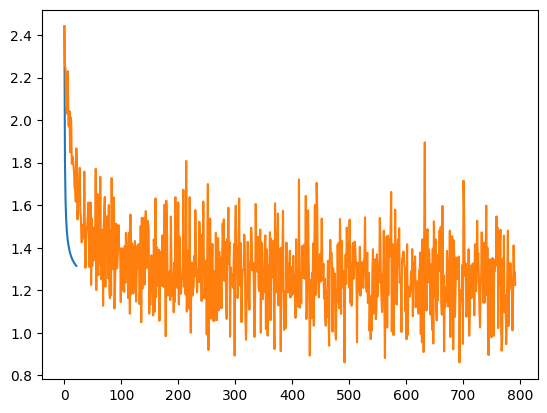

loss: 1.3114, epoch: 22, batch: 0
New learning rate: 0.0001


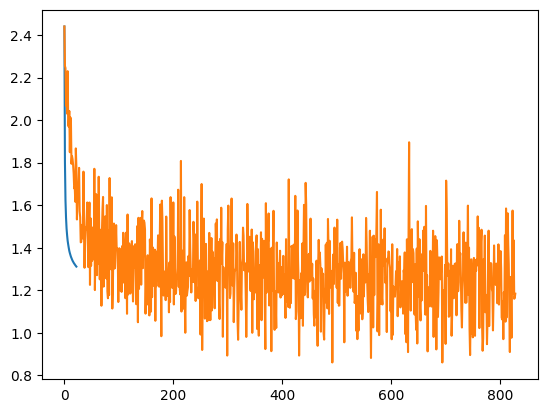

loss: 1.3082, epoch: 23, batch: 0
New learning rate: 0.0001


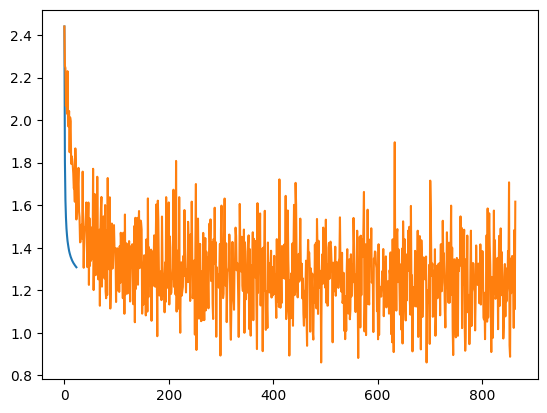

loss: 1.3058, epoch: 24, batch: 0
New learning rate: 0.0001


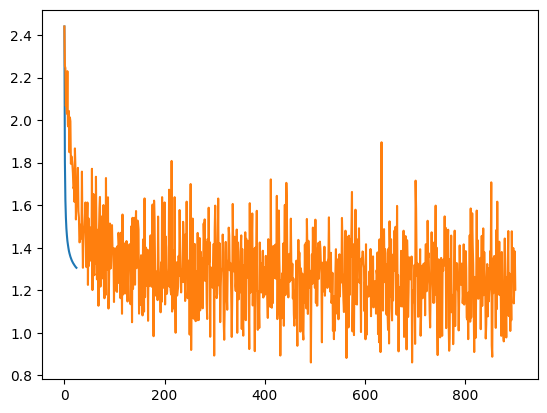

loss: 1.3026, epoch: 25, batch: 0
New learning rate: 0.0001


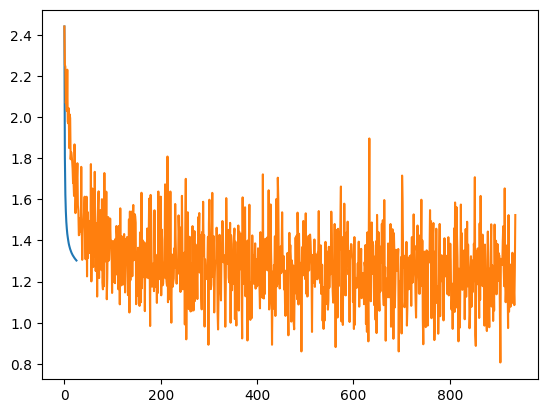

loss: 1.3003, epoch: 26, batch: 0
New learning rate: 0.0001


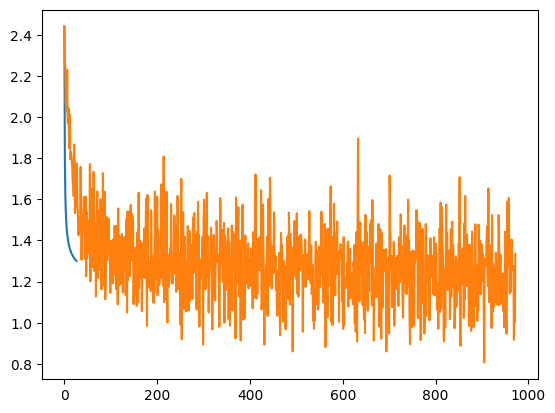

loss: 1.2976, epoch: 27, batch: 0
New learning rate: 0.0001


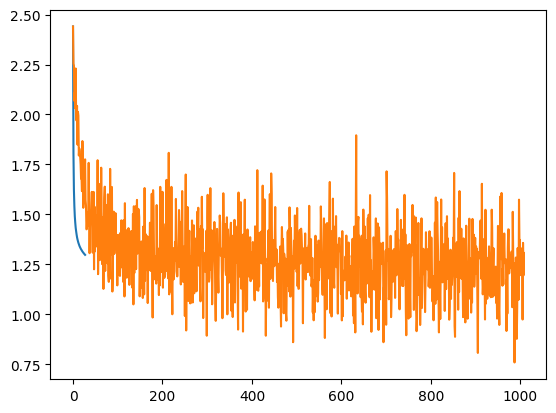

loss: 1.2952, epoch: 28, batch: 0
New learning rate: 0.0001


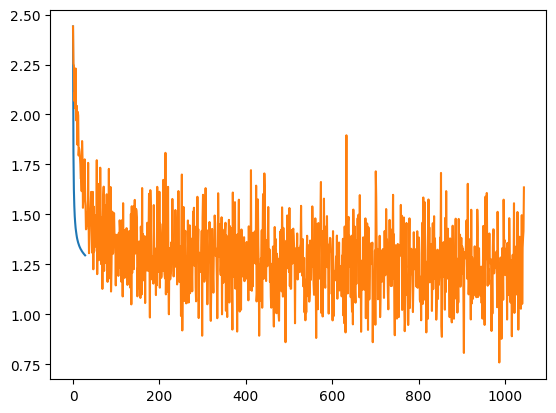

loss: 1.2933, epoch: 29, batch: 0
New learning rate: 0.0001


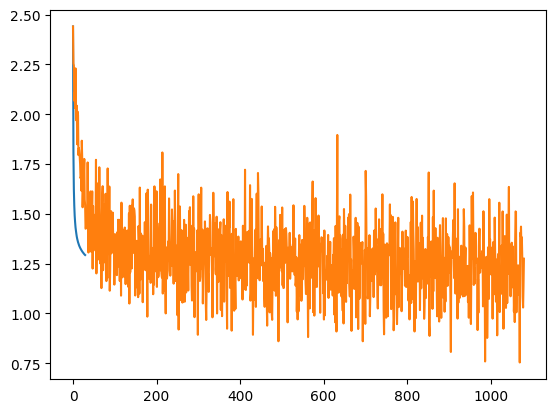

loss: 1.2909, epoch: 30, batch: 0
New learning rate: 0.0001


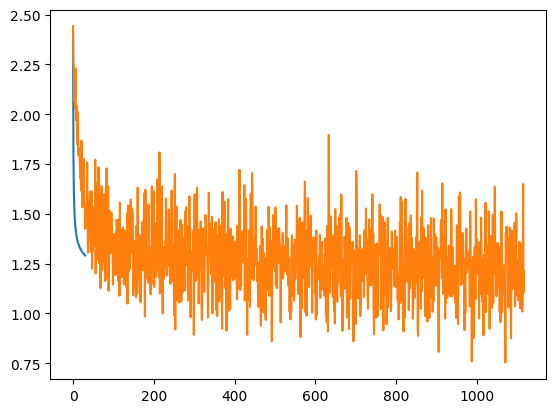

loss: 1.2888, epoch: 31, batch: 0
New learning rate: 0.0001


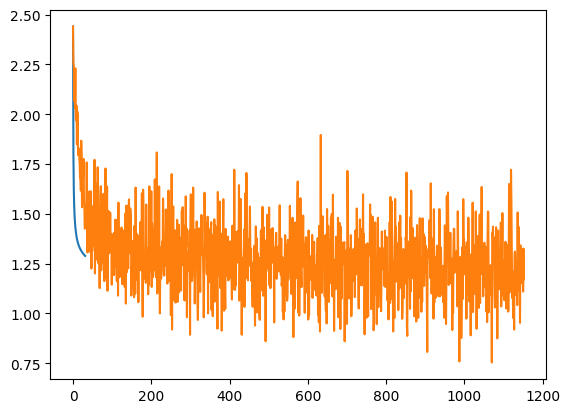

loss: 1.2869, epoch: 32, batch: 0
New learning rate: 0.0001


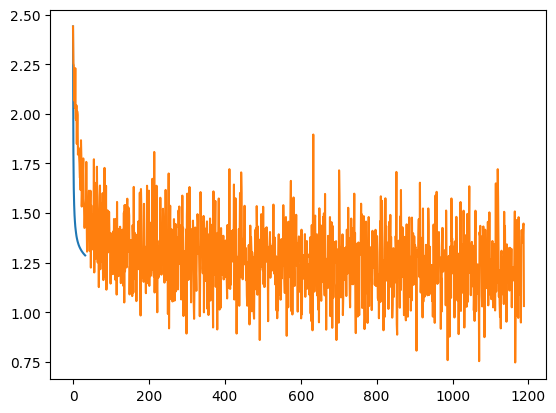

loss: 1.2849, epoch: 33, batch: 0
New learning rate: 0.0001


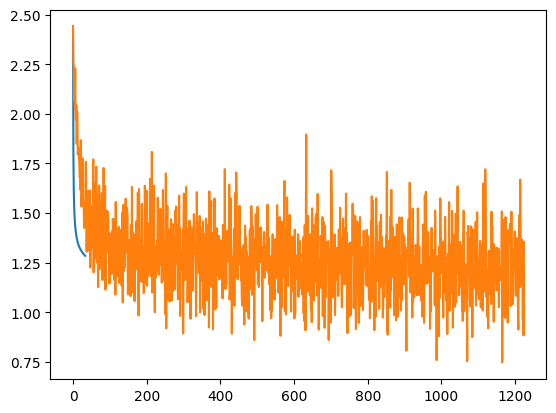

loss: 1.2834, epoch: 34, batch: 0
New learning rate: 0.0001


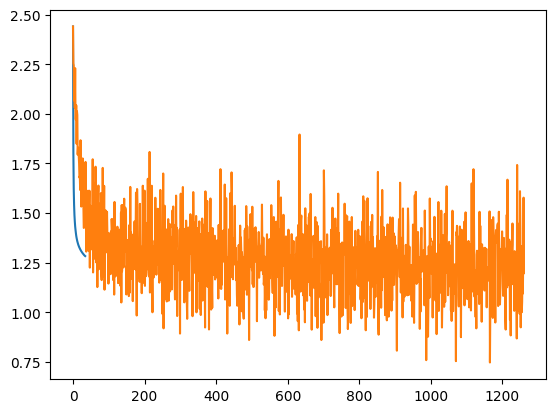

loss: 1.2817, epoch: 35, batch: 0
New learning rate: 0.0001


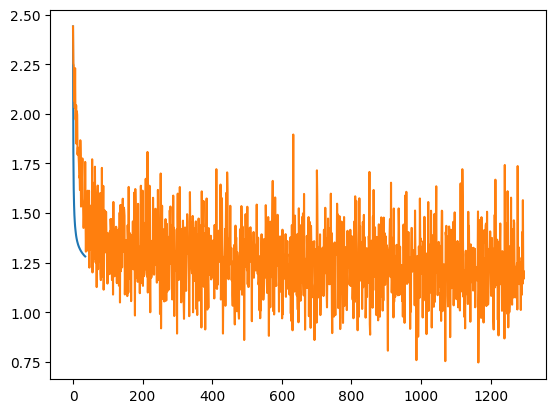

loss: 1.2801, epoch: 36, batch: 0
New learning rate: 0.0001


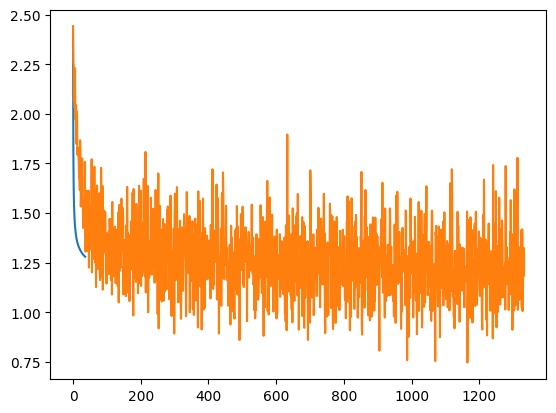

loss: 1.2785, epoch: 37, batch: 0
New learning rate: 0.0001


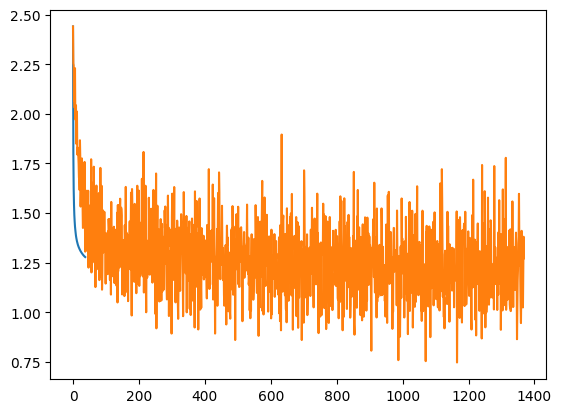

loss: 1.2771, epoch: 38, batch: 0
New learning rate: 0.0001


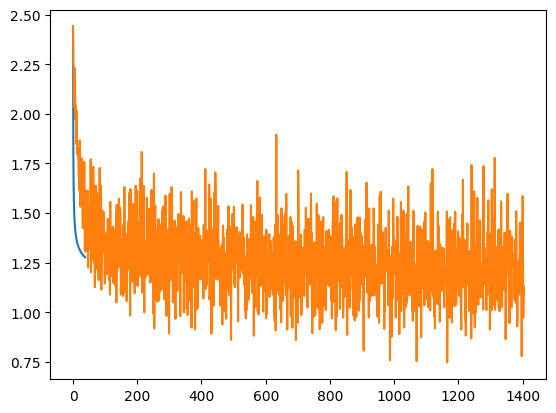

loss: 1.2756, epoch: 39, batch: 0
New learning rate: 0.0001


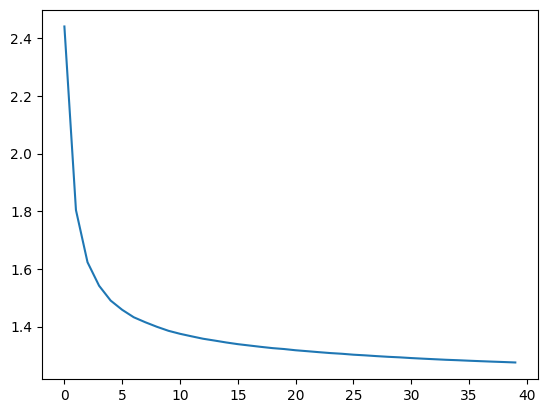

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
our_vae = vae().to(device)
dataset = marioDataset(path_dir='data/mario/',num_frames=1, transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(our_vae.parameters(), lr=0.0001)

# Function to update learning rate
def update_learning_rate(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

losses = []
losses_mean = []
num_epochs = 40
# Iterate through the DataLoader
for epoch in range(num_epochs):
    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()
        input = batch.view(-1, 3, 64, 64).to(device)
        loss, _, _ = our_vae(input)
        loss.backward()
        losses.append(loss.item())
        #print(f'loss: {loss.item():.4f}, epoch: {epoch}, batch: {i}')
        optimizer.step()
        if i % 1000 == 0:
            plt.plot(losses)
            plt.show()
            loss_mean = torch.tensor(losses).mean()
            losses_mean.append(loss_mean)
            print(f'loss: {loss_mean:.4f}, epoch: {epoch}, batch: {i}')
            pass
    plt.plot(losses_mean)
    learning_rate = 0.0001# * (0.1 ** (epoch / 10))
    print(f'New learning rate: {learning_rate}')
    update_learning_rate(optimizer, learning_rate)


epoch: 40, lr= 0.001, loss = 1.243


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


original image


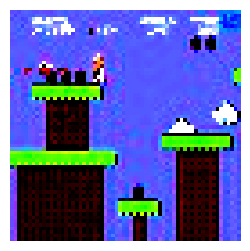

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.7842023].


reconstructed image


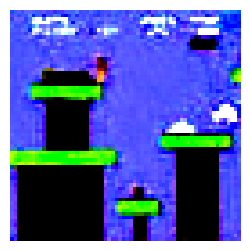

In [70]:
sample_image(our_vae, dataset)